In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import pandas
from sklearn.metrics import mean_squared_error

def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

# Read data from file and return a generator of lines, each line is a dictionary
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
# read data from file and return a generator of user, game, and dictionary
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d
# 
def UsersGames(data):
    usergames = defaultdict(set)
    gameusers = defaultdict(set)
    for u, g, d in data:
        usergames[u].add(g)
        gameusers[g].add(u)
    return usergames, gameusers


## 0 处理数据
读取userid gamesid playered hours, 然后划分训练集和验证集

In [3]:
# allData
allHours = []
for l in readJSON("/Users/zhiqiaogong/Projects/JupyterNotebook/cse258/hw3/train.json.gz"):
    allHours.append(l)
# split data into train and valid
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]

## 1 Play prediction
### 1.1 baseline：Popularity
仅依据游戏自自身的popularity来判断用户是否会玩这个游戏。
将所有游戏按照被提到的次数排序，
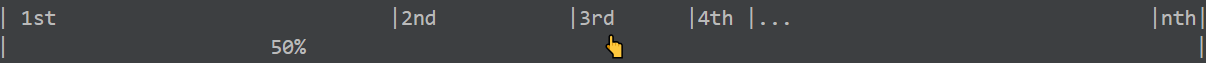
                    
假设情况如上图所示，那么对于所有用户，预测其玩过前三个游戏，不玩后面的游戏。



In [4]:
gameCount = defaultdict(int) # Number of times each game appears, store in dictionary, key is gameID, value is number of times it appears
totalPlayed = 0 # Total number of games appeared ( counts duplicates )

for user,game,_ in hoursTrain:
    gameCount[game] += 1
    totalPlayed += 1

# calculate the most popular games
mostPopular = [(gameCount[x], x) for x in gameCount] # number of times a game appears, gameID 
mostPopular.sort()
mostPopular.reverse()
return1 = set() # set of most popular games
count = 0

# for ic, i in mostPopular:
#   count += ic
#   return1.add(i)
#   if count > totalPlayed*0.7: break

# 根据28定理设的新方案
for ic, i in mostPopular:
  count += 1
  return1.add(i)
  if count > len(gameCount)*0.20: break
 



def get_prediction(u,g):
    if g in return1:
        return 1
    else:
        return 0

### Question 1
# Evaluate baseline strategy
allGames = set([g for u, g, d in hoursTrain + hoursValid]) # 所有gameid的集合

usergames,gameusers = UsersGames(hoursTrain + hoursValid) # usergames: 每个user玩过的game; gameusers:每个game的user

augmentedValidationSet = []

valid1 = []
valid2 = []

answers = {}
for u,i,d in hoursValid:
    valid1.append((u, i, 1))
    valid2.append((u, random.choice(list(allGames - usergames[u])), 0))
augmentedValidationSet = valid1 + valid2 # 加入一些用户没玩过的游戏作为负样本

predictions = [1 if get_prediction(u, g)==p else 0 for u,g,p in augmentedValidationSet]
accuracy = sum(predictions)/len(augmentedValidationSet)

answers['Q1'] = accuracy
assertFloat(answers['Q1'])
print(accuracy)

0.7009700970097009


### 1.2 调整baseline参数

In [5]:
# Improved strategy
threshold = 2.7 * totalPlayed / 5

return12 = set()
count2 = 0
for ic, i in mostPopular:
  count2 += ic
  return12.add(i)
  if count2 > threshold: break

def get_prediction2(u,g):
    if g in return12:
        return 1
    else:
        return 0

# Evaluate baseline strategy
predictions = [1 if get_prediction2(u, g)==p else 0 for u,g,p in augmentedValidationSet]

accuracy = sum(predictions)/len(augmentedValidationSet)
answers['Q2'] = [accuracy, 100*2/3]
assertFloatList(answers['Q2'], 2)

print(accuracy)

0.6939193919391939


### 1.3 Jaccard similarity

In [6]:
usergames_train,gameusers_train = UsersGames(hoursTrain)
# 返回两个序列的Jaccard相似度
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

# 
def predictJaccard(u,g):
    maxJaccrd = 0
    threshold34 = 0.03035
    predictionsJaccard = []
    gamesset = usergames_train.get(u)
    if gamesset is None:
        return 0
    for g1 in gamesset:
        if g==g1:
            continue
        j = Jaccard(gameusers_train.get(g1),gameusers_train.get(g))
        if j>maxJaccrd:
            maxJaccrd = j
    if maxJaccrd > threshold34:
        return 1
    else:
        return 0

predictions = [predictJaccard(u, g)==p for u,g,p in augmentedValidationSet]
accuracy3 = sum(predictions)/len(augmentedValidationSet)
print(accuracy3)


0.6795179517951795


### 1.4 调整Jaccard similarity参数 并结合popularity

In [7]:
threshold = 2 * totalPlayed / 3

return13 = set()
count3 = 0
for ic, i in mostPopular:
  count3 += ic
  return13.add(i)
  if count3 > threshold: break

def get_prediction3(u,g):
    if g in return13:
        return 1
    else:
        return 0

predictions = [1 if get_prediction3(u, g) or predictJaccard(u, g) else 0 for u,g,p in augmentedValidationSet]
accuracy4 = sum([p == l for p, l in zip([p for u,d,p in augmentedValidationSet], predictions)]) / len(augmentedValidationSet)
answers['Q3'] = accuracy3
answers['Q4'] = accuracy4
assertFloat(answers['Q3'])
assertFloat(answers['Q4'])

return14 = set()
count4 = 0
for ic, i in mostPopular:
  count4 += ic
  return14.add(i)
  if count4 > threshold: break

def get_prediction4(u,g):
    if g in return14:
        return 1
    else:
        return 0


predictions = open("predictions_Played.csv", 'w')
for l in open("/Users/zhiqiaogong/Projects/JupyterNotebook/cse258/hw3/pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    baselinepre = get_prediction4(u, g)
    jpre = predictJaccard(u, g)
    if baselinepre or jpre:
        pred = 1
    else:
        pred = 0

    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()
answers['Q5'] = "I confirm that I have uploaded an assignment submission to gradescope"

print(accuracy4)


0.6891189118911891


### 1.5 SOTA
思路：
第一步：筛选出popularity高的游戏以及jackard similarity高的游戏，认为用户会玩这些游戏

第二步：逐步降低阈值，直到pred中的true达到50%

**注意** ： 必须在一开始的时候就将整个测试集读进来，否则没法保证最后的分类结果是55开的。

In [32]:
import numpy as np
def calJaccardScore(u,g):
    maxJaccrd = 0
    gamesset = usergames_train.get(u)
    if gamesset is None:
        return 0
    for g1 in gamesset:
        if g==g1:
            continue
        j = Jaccard(gameusers_train.get(g1),gameusers_train.get(g))
        if j>maxJaccrd:
            maxJaccrd = j
    return maxJaccrd

gt = [p for _,_,p in augmentedValidationSet]
gt = np.asarray(gt)

def cal_hyper(u,g):
    jacc_score = np.zeros(len(u))
    val_user_count = np.zeros(len(g))
    for i in range(len(u)):
        jacc_score[i] = calJaccardScore(u[i], g[i])
        val_user_count[i] = len(gameusers_train.get(g[i]))


    count = 0
    pop_high_count = 0
    pop_low_count = 0
    # 根据28定理设的新方案
    for ic, i in mostPopular:
        count += ic
        if count > len(gameCount)*0.2: 
            pop_high_count = ic
            break

    count = 0
    for ic, i in mostPopular:
        count += 1
        if count > len(gameCount)*0.80: 
            pop_low_count = ic    
            break
    print("pop_high_count: ", pop_high_count, "pop_low_count: ", pop_low_count)
    pred = np.zeros(len(g))

    pred = np.zeros(len(g))
    jacc_high = (jacc_score > 0.05)
    jacc_low = (jacc_score <= 0.020)
    pop_high = (val_user_count > pop_high_count)
    pop_low = (val_user_count <= pop_low_count)
    low = np.logical_or(jacc_low, pop_low)
    heigh = np.logical_or(jacc_high, pop_high)
    sure = np.logical_or(low, heigh)
    not_sure = np.logical_not(sure)
    print(heigh)
    pred[low] = 0
    pred[heigh] = 1
    not_sure = np.array([True]*len(pred))
    res_true = len(pred)/2        
    js = 0.05
    pc = pop_high_count
    while res_true>0:
        js -= 0.0001
        pc -= 10
        # print("js: ", js, "pc: ", pc, "res_true: ", res_true)
        for i in range(len(pred)):
            if not_sure[i]:
                if jacc_score[i] > js or val_user_count[i] > pc:
                    pred[i] = 1
                    res_true -= 1
                    not_sure[i] = False
            if res_true <= 0:
                break
    
    # print("js: ", js, "pc: ", pc)
    return pred,js,pc, 0.020, pop_low_count

user = [u for u,_,_ in augmentedValidationSet]
game = [g for _,g,_ in augmentedValidationSet]
_, tuned_js, tuned_pc, jacc_low_score, pop_low_count = cal_hyper(user, game)
print("tuned_js: ", tuned_js, "tuned_pc: ", tuned_pc, "jacc_low_score: ", jacc_low_score, "pop_low_count: ", pop_low_count)



pop_high_count:  1038 pop_low_count:  20
[False False False ... False  True False]
tuned_js:  0.040299999999999725 tuned_pc:  68 jacc_low_score:  0.02 pop_low_count:  20


In [9]:
# 用调好的参数计算结果
def predict(u,g):
    jsc = calJaccardScore(u,g)
    psc = len(gameusers_train.get(g))
    if jsc < jacc_low_score or psc < pop_low_count:
        return 0 
    if jsc > tuned_js or psc > tuned_pc:
        return 1
    else:
        return 0

pred = []
tc = 0 # true count
for u,g,p in augmentedValidationSet:
    if predict(u,g) == p:
        tc += 1
    if tc < len(augmentedValidationSet)/2:
        pred.append(predict(u,g))
    else: 
        pred.append(0)  


In [10]:
pred = np.asarray(pred)
acc = np.sum(pred==gt)/len(gt)
print(acc)

0.7928792879287929


In [34]:
def read_csv_file(file_path):
    user_ids = []
    game_ids = []
    for l in open(file_path):
        if l.startswith("userID"):
            continue
        u,g = l.strip().split(',')
        user_ids.append(u)
        game_ids.append(g)

    return user_ids, game_ids

# Example usage
# user_ids, game_ids = read_csv_file('path_to_your_test.csv')

In [38]:
predictions = open("predictions_Played.csv", 'w')
user, game = read_csv_file("/Users/zhiqiaogong/Projects/JupyterNotebook/cse258/hw3/pairs_Played.csv")
pred0, tuned_js, tuned_pc, jacc_low_score, pop_low_count = cal_hyper(user, game)
print(pred0)
i=0
for l in open("/Users/zhiqiaogong/Projects/JupyterNotebook/cse258/hw3/pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    # jsc = calJaccardScore(u,g)
    # psc = len(gameusers_train.get(g))
    # if jsc < jacc_low_score or psc < pop_low_count:
    #     pred = 0 
    # if jsc > tuned_js or psc > tuned_pc:
    #     pred = 1
    # else:
    #     pred = 0

    _ = predictions.write(u + ',' + g + ',' + str(pred0[i]) + '\n')
    i+=1
predictions.close()

pop_high_count:  1038 pop_low_count:  20
[False  True False ... False False  True]
[1. 1. 1. ... 1. 1. 1.]


In [25]:
game

['g41031307',
 'g62450068',
 'g71021765',
 'g26732871',
 'g69433247',
 'g57175884',
 'g01435414',
 'g66197269',
 'g10053132',
 'g75228197',
 'g59833534',
 'g90153689',
 'g62353511',
 'g42729032',
 'g39879078',
 'g18049686',
 'g08346452',
 'g54506405',
 'g96198443',
 'g48341630',
 'g03916495',
 'g30786147',
 'g14479207',
 'g40485117',
 'g02325217',
 'g61264440',
 'g35252974',
 'g69849525',
 'g84994417',
 'g19440662',
 'g44688036',
 'g41031307',
 'g21519849',
 'g21519849',
 'g35549655',
 'g85599208',
 'g05914065',
 'g26556480',
 'g84633727',
 'g42111697',
 'g33067795',
 'g67170903',
 'g53927674',
 'g16158766',
 'g29390929',
 'g09698387',
 'g13943116',
 'g28112086',
 'g15540544',
 'g61018623',
 'g09572072',
 'g95846609',
 'g53999958',
 'g91663233',
 'g77960728',
 'g16903439',
 'g68576640',
 'g56721077',
 'g41905064',
 'g84367501',
 'g59027363',
 'g27727435',
 'g45950487',
 'g06045292',
 'g57658162',
 'g71371078',
 'g04423005',
 'g83853612',
 'g71690287',
 'g14542017',
 'g60790435',
 'g363